In [1]:
__authors__ = "Anton Gochev, Jaro Habr, Yan Jiang, Samuel Kahn"
__version__ = "XCS224u, Stanford, Spring 2021"

## Colours with static embeddings

1. [Setup](#Setup)
1. [Dataset](#Dataset)
    1. [Filtered Corpus](#Filtered-Corpus)
    1. [Bake-Off Corpus](#Bake-Off-Corpus)
1. [Baseline-System](#Baseline-System)
1. [Experiments](#Experiments)
  1. [BERT Embeddings](#BERT-Embeddings)
  2. [XLNet Embeddings](#XLNet-Embeddings)
  3. [RoBERTa Embeddings](#RoBERTa-Embeddings)
  4. [ELECTRA Embeddings](#ELECTRA-Embeddings)

## Setup

This notebook explores the performance of the basemodel with using different pre-trained static embeddings extracted from transformers such as BERT, XLNet, RoBERTa, ELECTRA

In [69]:
from utils.colors import ColorsCorpusReader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from utils.torch_color_describer import ContextualColorDescriber, create_example_dataset
import utils.utils
from utils.utils import UNK_SYMBOL, START_SYMBOL, END_SYMBOL
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import numpy as np
from baseline.model import (
    BaselineTokenizer, BaselineColorEncoder,
    BaselineEmbedding, BaselineDescriber, 
    GloVeEmbedding, BaselineLSTMDescriber    
)

from transformers import (
    BertTokenizer, BertModel,
    XLNetTokenizer, XLNetModel,
    RobertaTokenizer, RobertaModel,
    ElectraTokenizer, ElectraModel,    
)

import utils.model_utils as mu
import experiment.helper as eh
import matplotlib.pyplot as plt

## Dataset

This exploration of the dataset counts the examples for different classes and plots the words distribition in order to see any data imbalance issues.

### Filtered Corpus

The filtered corpus is the full dataset used in assignment 4. The following code looks at the composition of the dataset, the number of example in each condition as well as the word count used in the color descriptions.

In [3]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv"
)

In [4]:
corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True
)

In [5]:
examples = list(corpus.read())

In [6]:
len(examples)

46994

In [7]:
subset_examples = mu.extract_colour_examples(examples, from_word_count=5)

To understand the datasets (training and bake-off) in more details refer to [colors_in_context.ipynb](colors_in_context.ipynb). The notebook shows the distribution of the colours examples among the different splits.

### Bake-Off Corpus

The following code analyses the bake-off dataset. We will look at the number of examples for each of the conditions as well as the word count used to described the colors.

In [8]:
BAKE_OFF_COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "cs224u-colors-bakeoff-data.csv"
)

In [9]:
bake_off_corpus = ColorsCorpusReader(
    BAKE_OFF_COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True
)

In [10]:
bake_off_examples = list(bake_off_corpus.read())

In [11]:
len(bake_off_examples)

2031

## Baseline-System

This baseline system is based on assignment 4 and we use different token embeddings and sequences.

### Model training - full dataset

The full color context dataset is used for final baseline model training.

In [12]:
rawcols, texts = zip(*[[ex.colors, ex.contents] for ex in examples]) 
raw_colors_test_bo, texts_test_bo = zip(*[[ex.colors, ex.contents] for ex in bake_off_examples])

raw_colors_train, raw_colors_test, texts_train, texts_test = \
        train_test_split(rawcols, texts)

In [13]:
color_encoder = BaselineColorEncoder()

In [14]:
%time colors_train, colors_test, colors_test_bo = \
    eh.create_colours_sets(color_encoder, raw_colors_train, raw_colors_test, raw_colors_test_bo)

CPU times: user 3.7 s, sys: 94.6 ms, total: 3.8 s
Wall time: 3.81 s


In [15]:
hidden_dims = [50, 100, 150, 250]
start_index = 7000
end_index = 15000

In [16]:
colors = {'train': colors_train, 'test': colors_test, 'bo': colors_test_bo}

## Experiments

The notebook contains results produced with the baseline architecture and with different static embeddings and RNN units. We use GRU and LSTM units. LSTM shows a slightly better accuracy results and worse BLEU scores. 

In order to run the experiments using different embeddings:
- for GRU - use BaselineDescriber
- for LSTM - use BaselineLSTMDescriber

In the code in this notebook this is the only change you have to make to experiment with one or the other.

Results from the experiments:

| Model | Protocol | Cell | Training Results | Bake-off Results |
| --- | --- | --- | --- | --- |
| BERT 'bert-base-cased' | GRU | Stopping after epoch 54. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 115.87914156913757 CPU times: user 2h 4min 43s, sys: 1h 1min 36s, total: 3h 6min 19s Wall time: 1h 3min 47s | {'listener_accuracy': 0.8282407013362839, 'corpus_bleu': 0.4614753491619744} | {'listener_accuracy': 0.9034958148695224, 'corpus_bleu': 0.6637981882180088} |
| BERT 'bert-base-cased' | LSTM | Stopping after epoch 83. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 76.14108896255493 CPU times: user 3h 3min 25s, sys: 1h 27min 37s, total: 4h 31min 2s  Wall time: 1h 30min 36s | {'listener_accuracy': 0.8422844497404034, 'corpus_bleu': 0.4628617489092576} | {'listener_accuracy': 0.9084194977843427, 'corpus_bleu': 0.663598646435816} |
| BERT 'bert-base-cased' special symbols | LSTM | Stopping after epoch 75. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 78.7929949760437 CPU times: user 2h 56min 3s, sys: 1h 20min 28s, total: 4h 16min 32s Wall time: 1h 25min 22s | {'listener_accuracy': 0.8330921780577071, 'corpus_bleu': 0.6046802892558933} | {'listener_accuracy': 0.9069423929098966, 'corpus_bleu': 0.775147191199257} |
| XLNet 'xlnet-base-cased' | GRU | Stopping after epoch 55. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 117.36168694496155 CPU times: user 2h 18min 38s, sys: 1h 7min 4s, total: 3h 25min 43s Wall time: 1h 9min 34s | {'listener_accuracy': 0.8243254745084688, 'corpus_bleu': 0.4290345340732608} | {'listener_accuracy': 0.9034958148695224, 'corpus_bleu': 0.6462354138567806} |
| XLNet 'xlnet-base-cased' | LSTM | Stopping after epoch 61. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 107.04569149017334 CPU times: user 2h 44min 52s, sys: 1h 13min 37s, total: 3h 58min 29s Wall time: 1h 20min 2s | {'listener_accuracy': 0.8394757000595795, 'corpus_bleu': 0.43106009125838857} | {'listener_accuracy': 0.9148202855736091, 'corpus_bleu': 0.6450470273203873} |
| XLNet 'xlnet-base-cased' special symbols | LSTM | Stopping after epoch 62. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 102.59168982505798 CPU times: user 2h 36min 5s, sys: 1h 10min 41s, total: 3h 46min 46s Wall time: 1h 15min 4s | {'listener_accuracy': 0.8413481998467954, 'corpus_bleu': 0.6034250146753126} | {'listener_accuracy': 0.9089118660758247, 'corpus_bleu': 0.7685794289095298} |
| XLNet 'xlnet-base-cased' special symbols (train) | LSTM | Stopping after epoch 84. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 81.18819379806519 CPU times: user 5h 52min 11s, sys: 2h 10min 57s, total: 8h 3min 9s Wall time: 2h 31min 26s | {'listener_accuracy': 0.8369222912588306, 'corpus_bleu': 0.601674790521851} | {'listener_accuracy': 0.9162973904480551, 'corpus_bleu': 0.7722886437345147} |
| XLNet 'xlnet-base-cased' special symbols (hidden_dim=150) | LSTM | Stopping after epoch 50. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 125.70396375656128 CPU times: user 4h 48min 33s, sys: 1h 28min 54s, total: 6h 17min 27s Wall time: 2h 20min 18s | {'listener_accuracy': 0.8485828581155843, 'corpus_bleu': 0.6085643884234092} | {'listener_accuracy': 0.9094042343673068, 'corpus_bleu': 0.773156024030461} |
| XLNet 'xlnet-base-cased' special symbols (hidden_dim=250) | LSTM | Stopping after epoch 31. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 153.3585443496704 CPU times: user 3h 53min 7s, sys: 1h 5min 47s, total: 4h 58min 55s Wall time: 2h 6min 15s | {'listener_accuracy': 0.8519874031832496, 'corpus_bleu': 0.5981626269467012} | {'listener_accuracy': 0.9148202855736091, 'corpus_bleu': 0.7656988963667536} |
| XLNet 'xlnet-base-cased' special symbols (hidden_dim=250) | GRU | Stopping after epoch 40. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 140.58764219284058 CPU times: user 4h 27min 25s, sys: 1h 16min 31s, total: 5h 43min 57s Wall time: 2h 20min 7s | {'listener_accuracy': 0.8495191080091923, 'corpus_bleu': 0.6146655829350531} | {'listener_accuracy': 0.9079271294928607, 'corpus_bleu': 0.7742184170218822} |
| RoBERTa 'roberta-base' | GRU | Stopping after epoch 71. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 88.95393252372742 CPU times: user 2h 26min 29s, sys: 1h 11min 9s, total: 3h 37min 38s Wall time: 1h 10min 30s | {'listener_accuracy': 0.8160694527193804, 'corpus_bleu': 0.43914107019568926} | {'listener_accuracy': 0.8936484490398818, 'corpus_bleu': 0.6365891729377956} |
| RoBERTa 'roberta-base' | LSTM | Stopping after epoch 61. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 111.48405265808105 CPU times: user 2h 41min 37s, sys: 1h 11min 45s, total: 3h 53min 23s Wall time: 1h 15min 32s | {'listener_accuracy': 0.8200697931738872, 'corpus_bleu': 0.39418980395247344} | {'listener_accuracy': 0.8941408173313639, 'corpus_bleu': 0.5649086521910678} |
| RoBERTa 'roberta-base' with special symbols| LSTM | Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 183.6977562904358 CPU times: user 36min 46s, sys: 15min 12s, total: 51min 58s Wall time: 16min 31s | {'listener_accuracy': 1.0, 'corpus_bleu': 0.14391863137288283} | {'listener_accuracy': 1.0, 'corpus_bleu': 0.14266371245691778} |
| ELECTRA 'google/electra-small-discriminator' | GRU | Stopping after epoch 55. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 112.70061588287354 CPU times: user 1h 18min 13s, sys: 33min 6s, total: 1h 51min 20s Wall time: 37min 34s | {'listener_accuracy': 0.8459443356881436, 'corpus_bleu': 0.4808836633817978} | {'listener_accuracy': 0.914327917282127, 'corpus_bleu': 0.6813010156866868} |
| ELECTRA 'google/electra-small-discriminator' | LSTM | Stopping after epoch 79. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 80.59795188903809 CPU times: user 2h 2min 9s, sys: 47min 40s, total: 2h 49min 49s Wall time: 56min 50s | {'listener_accuracy': 0.8423695633670951, 'corpus_bleu': 0.47554009108512063} | {'listener_accuracy': 0.9187592319054653, 'corpus_bleu': 0.6793120721302932} |
| ELECTRA 'google/electra-small-discriminator' with special symbols | LSTM | Stopping after epoch 89. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 62.53766906261444 CPU times: user 3h 25min 42s, sys: 1h 13min 46s, total: 4h 39min 29s Wall time: 1h 33min 28s | {'listener_accuracy': 0.8384543365392799, 'corpus_bleu': 0.6157523870047085} | {'listener_accuracy': 0.9231905465288035, 'corpus_bleu': 0.7868532977802751} |
| ELECTRA 'google/electra-small-discriminator' with special symbols (hidden-dim=250) | LSTM | Stopping after epoch 47. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 129.40360379219055 CPU times: user 4h 12min 12s, sys: 1h 1min 51s, total: 5h 14min 3s Wall time: 2h 7min 56s | {'listener_accuracy': 0.8506255851561835, 'corpus_bleu': 0.6293721827603683} | {'listener_accuracy': 0.9246676514032496, 'corpus_bleu': 0.7906790707715832} |
| ELECTRA 'google/electra-small-discriminator' with special symbols (hidden-dim=250) | GRU | Stopping after epoch 58. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 113.49334740638733 CPU times: user 4h 41min, sys: 1h 14min 36s, total: 5h 55min 37s Wall time: 2h 14min 4s | {'listener_accuracy': 0.8456889948080688, 'corpus_bleu': 0.6352155511560553} | {'listener_accuracy': 0.9158050221565731, 'corpus_bleu': 0.7919310994581112} |

### BERT Embeddings

In [17]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

In [18]:
%time tokens_train, tokens_test, tokens_test_bo = \
    eh.create_tokens_sets(bert_tokenizer, texts_train, texts_test, texts_test_bo)

CPU times: user 11.5 s, sys: 53.9 ms, total: 11.5 s
Wall time: 11.6 s


In [19]:
%time bert_embeddings, bert_vocab = mu.extract_input_embeddings(texts_train, bert_model, bert_tokenizer, add_special_tokens=True)

CPU times: user 10.9 s, sys: 64.4 ms, total: 11 s
Wall time: 11 s


***Experiment with different hidden_dim size***

| Results - BERT LSTM - static embeddings + Fourier |
| ------- |
| Stopping after epoch 65. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 43.77676248550415 <br /> train 50 - {'listener_accuracy': 0.5737509575283003, 'corpus_bleu': 0.551273387115109} <br /> bake-off 50 - {'listener_accuracy': 0.6686361398325947, 'corpus_bleu': 0.7282399951925177} |
| Stopping after epoch 77. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 41.856379985809326 <br /> train 100 - {'listener_accuracy': 0.6678866286492467, 'corpus_bleu': 0.5791491200908689} <br /> bake-off 100 - {'listener_accuracy': 0.7552929591334318, 'corpus_bleu': 0.7448639453166213} |
| Stopping after epoch 78. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 39.47101306915283 <br /> train 150 - {'listener_accuracy': 0.6924844667631288, 'corpus_bleu': 0.5844652937311282} <br /> bake-off 150 - {'listener_accuracy': 0.7680945347119645, 'corpus_bleu': 0.7505010909113622} |
| Stopping after epoch 61. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 42.89243769645691 <br /> train 250 - {'listener_accuracy': 0.6939313984168866, 'corpus_bleu': 0.5848634215857242} <br /> bake-off 250 - {'listener_accuracy': 0.7897587395371738, 'corpus_bleu': 0.7515672071967832} |

*Experiment time* <br /> 
CPU times: user 4h 16min 12s, sys: 1h 30min 54s, total: 5h 47min 7s
Wall time: 2h 9min 18s

| Results - BERT GRU - static embeddings + Fourier |
| ------- |
| Stopping after epoch 158. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 34.833738684654236 <br /> train 50 - {'listener_accuracy': 0.6869520810281726, 'corpus_bleu': 0.5745811641752091} <br /> bake-off 50 - {'listener_accuracy': 0.7754800590841949, 'corpus_bleu': 0.7529138407073789} |
| Stopping after epoch 128. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 37.71801567077637 <br /> train 100 - {'listener_accuracy': 0.7342752574687207, 'corpus_bleu': 0.5834740206954901} <br /> bake-off 100 - {'listener_accuracy': 0.8197932053175776, 'corpus_bleu': 0.7568374353569257} |
| Stopping after epoch 39. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 46.75967288017273 <br /> train 150 - {'listener_accuracy': 0.6313728827985361, 'corpus_bleu': 0.5449781903320903} <br /> bake-off 150 - {'listener_accuracy': 0.689807976366322, 'corpus_bleu': 0.6616414059980651} |
| Stopping after epoch 101. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 39.70299792289734 <br /> train 250 - {'listener_accuracy': 0.7568303685420036, 'corpus_bleu': 0.5744405898859896} <br /> bake-off 250 - {'listener_accuracy': 0.8478581979320532, 'corpus_bleu': 0.7554285945684138} |

*Experiment time* <br /> 
CPU times: user 7h 50min 42s, sys: 2h 36min 19s, total: 10h 27min 1s
Wall time: 3h 39min 59s

In [20]:
#tokens = {'train': tokens_train, 'test': tokens_test, 'bo': tokens_test_bo}

In [70]:
#### for GRU set unit='GRU'
#%time eh.run_hiddim_options(hidden_dims, start_index, end_index, bert_vocab, bert_embeddings, colors, tokens, unit='GRU')

***Baseline model using BERT pretrained embeddings and vocab***

In [37]:
baseline_model = BaselineLSTMDescriber(
    bert_vocab,
    embedding=bert_embeddings,
    early_stopping=True,
    hidden_dim=250
)

In [62]:
%time _ = baseline_model.fit(colors_train[10000:12000], tokens_train[10000:12000])

/Users/antongochev/ai-program/cs224u/repos/xcs224u_final_paper/code/utils/torch_color_describer.py:699: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 41. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 13.007397174835205

CPU times: user 6min 22s, sys: 2min 45s, total: 9min 7s
Wall time: 2min 54s


/Users/antongochev/opt/miniconda3/envs/nlu/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


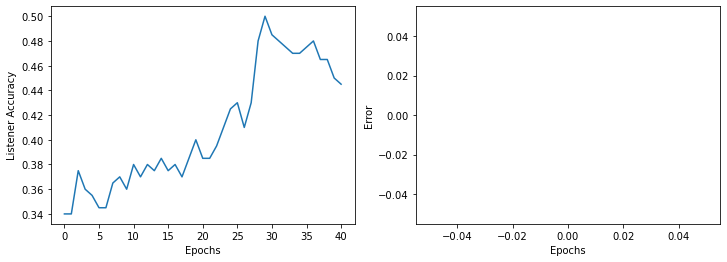

In [68]:
scores = baseline_model.validation_scores
errors = baseline_model.errors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1 = pd.Series(scores).plot(ax=ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Listener Accuracy")

ax2 = pd.Series(errors).plot(ax=ax2)
ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Error")

Evaluate on test data

In [67]:
%time baseline_model.evaluate(colors_test, tokens_test)

/Users/antongochev/ai-program/cs224u/repos/xcs224u_final_paper/code/utils/torch_color_describer.py:699: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


CPU times: user 40.8 s, sys: 4.23 s, total: 45 s
Wall time: 37 s


{'listener_accuracy': 0.4427610860498766, 'corpus_bleu': 0.5097921865057029}

Evaluate on bake-off data

In [ ]:
%time model.evaluate(colors_test_bo, tokens_test_bo)

### XLNet Embeddings

In [100]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetModel.from_pretrained('xlnet-base-cased')

In [101]:
%time tokens_train, tokens_test, tokens_test_bo = \
    eh.create_tokens_sets(xlnet_tokenizer, texts_train, texts_test, texts_test_bo)

CPU times: user 10.5 s, sys: 93.9 ms, total: 10.6 s
Wall time: 10.6 s


In [102]:
%time xlnet_embeddings, xlnet_vocab = mu.extract_input_embeddings(texts_train, xlnet_model, xlnet_tokenizer, add_special_tokens=True)

CPU times: user 10.1 s, sys: 217 ms, total: 10.3 s
Wall time: 10.6 s


***Experiment with different hidden_dim size***

| Results - XLNet LSTM - static embeddings + Fourier |
| ------- |
| Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 51.9597749710083 <br /> train 50 - {'listener_accuracy': 0.3853093880330241, 'corpus_bleu': 0.10116484200695276} <br /> bake-off 50 - {'listener_accuracy': 0.36484490398818314, 'corpus_bleu': 0.09590228916856602} |
| Stopping after epoch 90. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 42.36155438423157 <br /> train 100 - {'listener_accuracy': 0.6882287854285472, 'corpus_bleu': 0.5698094913260026} <br /> bake-off 100 - {'listener_accuracy': 0.758247168882324, 'corpus_bleu': 0.7385707180437213} |
| Stopping after epoch 85. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 41.34174728393555 <br /> train 150 - {'listener_accuracy': 0.7078049195676228, 'corpus_bleu': 0.5670989760716262} <br /> bake-off 150 - {'listener_accuracy': 0.7897587395371738, 'corpus_bleu': 0.740596578337375} |
| Stopping after epoch 44. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 45.056150794029236 <br /> train 250 - {'listener_accuracy': 0.6500978806706954, 'corpus_bleu': 0.545740385663943} <br /> bake-off 250 - {'listener_accuracy': 0.7380600689315608, 'corpus_bleu': 0.6353531455036665} |

*Experiment time*  <br /> 
CPU times: user 3h 31min 3s, sys: 1h 12min 56s, total: 4h 43min 59s
Wall time: 1h 46min 28s

| Results - XLNet GRU - static embeddings + Fourier |
| ------- |
| Stopping after epoch 23. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 51.38224458694458 <br /> train 50 - {'listener_accuracy': 0.47127415099157377, 'corpus_bleu': 0.419500335874233} <br /> bake-off 50 - {'listener_accuracy': 0.47464303298867555, 'corpus_bleu': 0.6039232114137115} |
| Stopping after epoch 134. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 38.57462525367737 <br /> train 100 - {'listener_accuracy': 0.7168269639969359, 'corpus_bleu': 0.562739465994163} <br /> bake-off 100 - {'listener_accuracy': 0.794190054160512, 'corpus_bleu': 0.7433761164266197} |
| Stopping after epoch 101. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 41.59675168991089 <br /> train 150 - {'listener_accuracy': 0.7198910545578348, 'corpus_bleu': 0.5594537330250193} <br /> bake-off 150 - {'listener_accuracy': 0.8153618906942393, 'corpus_bleu': 0.7456811526196221} |
| Stopping after epoch 80. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 40.17812728881836 <br /> train 250 - {'listener_accuracy': 0.7341050302153375, 'corpus_bleu': 0.571417246325118} <br /> bake-off 250 - {'listener_accuracy': 0.8296405711472181, 'corpus_bleu': 0.7450614311770654} |

*Experiment time* <br /> 
CPU times: user 6h 48min 34s, sys: 2h 9min 36s, total: 8h 58min 10s
Wall time: 3h 19min

In [25]:
#tokens = {'train': tokens_train, 'test': tokens_test, 'bo': tokens_test_bo}

In [71]:
#### for GRU set unit='GRU'
#%time eh.run_hiddim_options(hidden_dims, start_index, end_index, xlnet_vocab, xlnet_embeddings, colors, tokens, unit='GRU')

***Baseline model using XLNet pretrained embeddings and vocab***

In [134]:
with open("data/experiments/electra_gru_vscores.txt", "w") as f:
    f.write(str(baseline_model_gru.validation_scores))

In [135]:
baseline_model_gru.errors

[]

In [111]:
baseline_model_xlnet_lstm_150 = baseline_model_xlnet_lstm

In [116]:
baseline_model_xlnet_lstm = BaselineLSTMDescriber(
    vocab=xlnet_vocab,
    embedding=xlnet_embeddings,
    early_stopping=True,
    hidden_dim=250
)

In [117]:
%time _ = baseline_model_xlnet_lstm.fit(colors_train, tokens_train)

Stopping after epoch 31. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 153.3585443496704

CPU times: user 3h 53min 7s, sys: 1h 5min 47s, total: 4h 58min 55s
Wall time: 2h 6min 15s


Evaluate on test data

In [118]:
%time baseline_model_xlnet_lstm.evaluate(colors_test, tokens_test)

CPU times: user 2min 2s, sys: 7.33 s, total: 2min 10s
Wall time: 1min 59s


{'listener_accuracy': 0.8519874031832496, 'corpus_bleu': 0.5981626269467012}

Evaluate on bake-off data

In [119]:
%time baseline_model_xlnet_lstm.evaluate(colors_test_bo, tokens_test_bo)

CPU times: user 19.8 s, sys: 991 ms, total: 20.8 s
Wall time: 19.1 s


{'listener_accuracy': 0.9148202855736091, 'corpus_bleu': 0.7656988963667536}

In [107]:
baseline_model_xlnet_gru = BaselineDescriber(
    vocab=xlnet_vocab,
    embedding=xlnet_embeddings,
    early_stopping=True,
    hidden_dim=250
)

In [108]:
%time _ = baseline_model_xlnet_gru.fit(colors_train, tokens_train)

Stopping after epoch 40. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 140.58764219284058

CPU times: user 4h 27min 25s, sys: 1h 16min 31s, total: 5h 43min 57s
Wall time: 2h 20min 7s


Evaluate on test data

In [109]:
%time baseline_model_xlnet_gru.evaluate(colors_test, tokens_test)

CPU times: user 1min 39s, sys: 6.79 s, total: 1min 46s
Wall time: 1min 36s


{'listener_accuracy': 0.8495191080091923, 'corpus_bleu': 0.6146655829350531}

Evaluate on bake-off data

In [110]:
%time baseline_model_xlnet_gru.evaluate(colors_test_bo, tokens_test_bo)

CPU times: user 13.2 s, sys: 652 ms, total: 13.9 s
Wall time: 12.6 s


{'listener_accuracy': 0.9079271294928607, 'corpus_bleu': 0.7742184170218822}

### RoBERTa Embeddings

In [27]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

In [28]:
%time tokens_train, tokens_test, tokens_test_bo = \
    eh.create_tokens_sets(roberta_tokenizer, texts_train, texts_test, texts_test_bo)

CPU times: user 11.8 s, sys: 167 ms, total: 11.9 s
Wall time: 12 s


In [29]:
%time roberta_embeddings, roberta_vocab = mu.extract_input_embeddings(texts_train, roberta_model, roberta_tokenizer, add_special_tokens=True)

CPU times: user 10.6 s, sys: 149 ms, total: 10.8 s
Wall time: 10.8 s


***Experiment with different hidden_dim size***

| Results - RoBERTa GRU - static embeddings + Fourier |
| ------- |
| Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 53.903138160705566 <br /> train 50 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.05289811898885011} <br /> bake-off 50 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.05167405219103889} |
| Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 50.174792528152466 <br /> train 100 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.08079836581836754} <br /> bake-off 100 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.07799113737075333} |
| Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 52.46453046798706 <br /> train 150 -{'listener_accuracy': 1.0, 'corpus_bleu': 0.1349561664822538} <br /> bake-off 150 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.1294928606597735} |
| Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 50.51566171646118 <br /> train 250 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.18624563792663204} <br /> bake-off 250 - {'listener_accuracy': 1.0, 'corpus_bleu': 0.1887247661250615} |

*Experiment time* <br /> 
CPU times: user 1h 17min 46s, sys: 21min 31s, total: 1h 39min 17s
Wall time: 37min 26s

In [72]:
#tokens = {'train': tokens_train, 'test': tokens_test, 'bo': tokens_test_bo}

In [73]:
#### for GRU set unit='GRU'
#%time eh.run_hiddim_options(hidden_dims, start_index, end_index, roberta_vocab, roberta_embeddings, colors, tokens, unit='GRU')

***Baseline model using RoBERTa pretrained embeddings and vocab***

In [ ]:
baseline_model = BaselineLSTMDescriber(
    roberta_vocab,
    embedding=roberta_embeddings,
    early_stopping=True,
    hidden_dim=250
)

In [ ]:
%time _ = baseline_model.fit(colors_train, tokens_train)

Evaluate on test data

In [ ]:
%time model.evaluate(colors_test, tokens_test)

Evaluate on bake-off data

In [ ]:
%time model.evaluate(colors_test_bo, tokens_test_bo)

### ELECTRA Embeddings

In [75]:
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
electra_model = ElectraModel.from_pretrained('google/electra-small-discriminator')

In [76]:
%time tokens_train, tokens_test, tokens_test_bo = \
    eh.create_tokens_sets(electra_tokenizer, texts_train, texts_test, texts_test_bo)

CPU times: user 10.9 s, sys: 94.1 ms, total: 11 s
Wall time: 11.1 s


In [77]:
%time electra_embeddings, electra_vocab = mu.extract_input_embeddings(texts_train, electra_model, electra_tokenizer, add_special_tokens=True)

CPU times: user 9.21 s, sys: 52.7 ms, total: 9.27 s
Wall time: 9.32 s


***Experiment with different hidden_dim size***

| Results - ELECTRA LSTM - static embeddings + Fourier |
| ------- |
| Stopping after epoch 22. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 47.817570209503174 <br /> train 50 - {'listener_accuracy': 0.4707634692314239, 'corpus_bleu': 0.5473145798897392} <br /> bake-off 50 - {'listener_accuracy': 0.5002461841457411, 'corpus_bleu': 0.606142524592626} |
| Stopping after epoch 45. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 45.81661248207092 <br /> train 100 - {'listener_accuracy': 0.5994552727891735, 'corpus_bleu': 0.5351929134361038} <br /> bake-off 100 - {'listener_accuracy': 0.6646971935007385, 'corpus_bleu': 0.7070163097906428} |
| Stopping after epoch 75. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 43.8264799118042 <br /> train 150 - {'listener_accuracy': 0.7038896927398076, 'corpus_bleu': 0.5957756337243006} <br /> bake-off 150 - {'listener_accuracy': 0.8119153126538651, 'corpus_bleu': 0.6815846824408468} |
| Stopping after epoch 95. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 39.852388858795166 <br /> train 250 - {'listener_accuracy': 0.7478934377393821, 'corpus_bleu': 0.5925318634616346} <br /> bake-off 250 - {'listener_accuracy': 0.8316100443131462, 'corpus_bleu': 0.7661060337651819} |

*Experiment time* <br />
CPU times: user 3h 32min 8s, sys: 58min 33s, total: 4h 30min 42s
Wall time: 1h 44min 13s

| Results - ELECTRA GRU - static embeddings + Fourier |
| ------- |
| Stopping after epoch 121. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 39.6423761844635 <br /> train 50 - {'listener_accuracy': 0.7026129883394332, 'corpus_bleu': 0.5884617750958049} <br /> bake-off 50 - {'listener_accuracy': 0.8015755785327425, 'corpus_bleu': 0.7615788252166957} |
| Stopping after epoch 127. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 38.083460092544556 <br /> train 100 - {'listener_accuracy': 0.7483190058728403, 'corpus_bleu': 0.5817982083135973} <br /> bake-off 100 - {'listener_accuracy': 0.8385032003938946, 'corpus_bleu': 0.7700025753183866} |
| Stopping after epoch 84. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 43.11088514328003 <br /> train 150 - {'listener_accuracy': 0.7295940080006809, 'corpus_bleu': 0.5903210648151918} <br /> bake-off 150 - {'listener_accuracy': 0.810930576070901, 'corpus_bleu': 0.7739216589116132} |
| Stopping after epoch 50. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 45.304715156555176 <br /> train 250 - {'listener_accuracy': 0.7044003744999574, 'corpus_bleu': 0.5910223958364655} <br /> bake-off 250 - {'listener_accuracy': 0.7986213687838504, 'corpus_bleu': 0.6925750394944707} |


*Experiment time* <br /> 
CPU times: user 5h 56min 33s, sys: 1h 39min 31s, total: 7h 36min 5s
Wall time: 2h 39min 14s

In [35]:
#tokens = {'train': tokens_train, 'test': tokens_test, 'bo': tokens_test_bo}

In [74]:
#### for GRU set unit='GRU'
#%time eh.run_hiddim_options(hidden_dims, start_index, end_index, electra_vocab, electra_embeddings, colors, tokens, unit='GRU')

***Baseline model using ELECTRA pretrained embeddings and vocab***

In [87]:
baseline_model_lstm = BaselineLSTMDescriber(
    electra_vocab,
    embedding=electra_embeddings,
    early_stopping=True,
    hidden_dim=250
)

In [88]:
%time _ = baseline_model_lstm.fit(colors_train, tokens_train)

Stopping after epoch 47. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 129.40360379219055

CPU times: user 4h 12min 12s, sys: 1h 1min 51s, total: 5h 14min 3s
Wall time: 2h 7min 56s


Evaluate on test data

In [89]:
%time baseline_model_lstm.evaluate(colors_test, tokens_test)

CPU times: user 1min 24s, sys: 6.05 s, total: 1min 30s
Wall time: 1min 19s


{'listener_accuracy': 0.8506255851561835, 'corpus_bleu': 0.6293721827603683}

Evaluate on bake-off data

In [90]:
%time baseline_model_lstm.evaluate(colors_test_bo, tokens_test_bo)

CPU times: user 12.5 s, sys: 581 ms, total: 13.1 s
Wall time: 11.8 s


{'listener_accuracy': 0.9246676514032496, 'corpus_bleu': 0.7906790707715832}

In [91]:
baseline_model_gru = BaselineDescriber(
    vocab=electra_vocab,
    embedding=electra_embeddings,
    early_stopping=True,
    hidden_dim=150
)

In [97]:
%time _ = baseline_model_gru.fit(colors_train, tokens_train)

Stopping after epoch 58. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 113.49334740638733

CPU times: user 4h 41min, sys: 1h 14min 36s, total: 5h 55min 37s
Wall time: 2h 14min 4s


Evaluate on test data

In [98]:
%time baseline_model_gru.evaluate(colors_test, tokens_test)

CPU times: user 1min 11s, sys: 5.42 s, total: 1min 16s
Wall time: 1min 8s


{'listener_accuracy': 0.8456889948080688, 'corpus_bleu': 0.6352155511560553}

Evaluate on bake-off data

In [99]:
%time baseline_model_gru.evaluate(colors_test_bo, tokens_test_bo)

CPU times: user 10.1 s, sys: 623 ms, total: 10.7 s
Wall time: 9.59 s


{'listener_accuracy': 0.9158050221565731, 'corpus_bleu': 0.7919310994581112}